In [1]:
import yfinance as yf
import pandas as pd

def fetch_stock_data(tickers):
    data = yf.download(tickers)['Close'].dropna()
    return data

In [32]:
data = fetch_stock_data(['PETR4.SA','WEGE3.SA','VALE3.SA','BBAS3.SA'])
data.tail()

[*********************100%***********************]  4 of 4 completed


Ticker,BBAS3.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Date,,,,
2025-03-17,28.459999,36.160000,57.099998,47.650002
2025-03-18,28.500000,36.189999,57.520000,47.650002
2025-03-19,28.389999,36.160000,57.419998,48.139999
2025-03-20,28.250000,36.240002,57.240002,47.900002
2025-03-21,28.370001,36.799999,57.450001,47.849998


In [4]:
import numpy as np
from scipy.optimize import minimize

def portfolio_stats(weights, returns_cov):
    portfolio_return = np.sum(returns_cov.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns_cov.cov()*252, weights)))
    return portfolio_return, portfolio_volatility

def negative_sharpe(weights, returns_cov, risk_free_rate=0.12):
    p_return, p_volatility = portfolio_stats(weights, returns_cov)
    return -(p_return - risk_free_rate) / p_volatility

def optimize_portfolio(returns_cov):
    num_assets = len(returns_cov.columns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_weights = num_assets * [1. / num_assets,]

    result = minimize(negative_sharpe, initial_weights, args=(returns_cov,), method='SLSQP',
                      bounds=bounds, constraints=constraints)

    return result.x

In [42]:
returns = data.pct_change().dropna()
returns_log = data.pct_change().apply(lambda x: np.log(1+x)).dropna()

In [44]:
returns_log.cov()

Ticker,BBAS3.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Ticker,,,,
BBAS3.SA,0.000687,0.000357,0.000237,0.000126
PETR4.SA,0.000357,0.000695,0.000308,0.000129
VALE3.SA,0.000237,0.000308,0.000622,0.000113
WEGE3.SA,0.000126,0.000129,0.000113,0.000421


In [46]:
optimized_weights = optimize_portfolio(returns_log)
optimized_weights

array([4.15532863e-02, 0.00000000e+00, 9.54097912e-18, 9.58446714e-01])

In [47]:
portfolio_cumulative = (returns @ optimized_weights + 1).cumprod()

In [48]:
portfolio_cumulative

Date
2000-01-04      0.964390
2000-01-05      0.964800
2000-01-06      0.881294
2000-01-07      0.880470
2000-01-10      0.882481
                 ...    
2025-03-17    412.170113
2025-03-18    412.194185
2025-03-19    416.190649
2025-03-20    414.116702
2025-03-21    413.775463
Length: 6331, dtype: float64

In [50]:
ret, vol = portfolio_stats(optimized_weights, returns_log)

In [51]:
f'Retorno anual: {ret:.2%}', f'Volatilidade anual: {vol:.2%}'

('Retorno anual: 23.56%', 'Volatilidade anual: 31.66%')

In [53]:
def monte_carlo_portfolios(returns, n_simulations=5000):
        results = []
        num_assets = len(returns.columns)
        
        for _ in range(n_simulations):
            weights = np.random.random(num_assets)
            weights /= np.sum(weights)
            ret = np.sum(returns.mean() * weights) * 252
            vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))
            sharpe = ret / vol
            results.append((weights, ret, vol, sharpe))

        results_df = pd.DataFrame(results, columns=['weights', 'return', 'volatility', 'sharpe'])
        return results_df.sort_values(by='sharpe', ascending=False)

monte_carlo_results = monte_carlo_portfolios(returns)
best_mc_weights = monte_carlo_results.iloc[0]['weights']
best_mc_weights

array([0.19523054, 0.0310604 , 0.20200751, 0.57170154])

In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from utils.data_fetcher import fetch_stock_data
from utils.optimizer import optimize_portfolio, portfolio_stats

st.title('📈 Otimização de Carteira com Markowitz')

# Seleção dinâmica do número de ações
num_stocks = st.slider('Selecione o número de ações:', min_value=2, max_value=10, value=3)

# Seleção dinâmica de ações
selected_stocks = []
cols = st.columns(num_stocks)
for i, col in enumerate(cols):
    stock = col.text_input(f'Ação {i+1}', value='PETR4.SA')
    selected_stocks.append(stock)

# Carrega dados
if st.button('Calcular Carteira Otimizada'):
    data = fetch_stock_data(selected_stocks)
    returns = data.pct_change().dropna()

    # Otimização
    optimized_weights = optimize_portfolio(returns)

    # Rentabilidade acumulada
    portfolio_cumulative = (returns @ optimized_weights + 1).cumprod()

    # Gráficos comparativos
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=portfolio_cumulative.index, y=portfolio_cumulative,
                             name='Carteira Otimizada'))

    # SELIC e Inflação exemplo (dados simulados ou reais)
    selic = (1 + 0.115)**(np.arange(len(portfolio_cumulative)) / 252)
    inflacao = (1 + 0.05)**(np.arange(len(portfolio_cumulative)) / 252)

    fig.add_trace(go.Scatter(x=portfolio_cumulative.index, y=selic,
                             name='SELIC'))
    fig.add_trace(go.Scatter(x=portfolio_cumulative.index, y=inflacao,
                             name='Inflação'))

    fig.update_layout(title='Rentabilidade da Carteira vs. Indicadores Econômicos',
                      xaxis_title='Data', yaxis_title='Rentabilidade Acumulada')
    st.plotly_chart(fig)

    # Estatísticas de risco e retorno
    ret, vol = portfolio_stats(optimized_weights, returns)
    st.subheader('Estatísticas Otimizadas da Carteira')
    st.write(f'Retorno anual: {ret:.2%}')
    st.write(f'Volatilidade anual: {vol:.2%}')

    # Ajuste interativo de risco-retorno
    risk_aversion = st.slider('Modifique interativamente o perfil de risco:',
                              min_value=0.01, max_value=1.0, value=0.5)

    adjusted_weights = risk_aversion * optimized_weights + (1 - risk_aversion) / len(optimized_weights)
    portfolio_cumulative_adj = (returns @ adjusted_weights + 1).cumprod()

    fig_adj = go.Figure()
    fig_adj.add_trace(go.Scatter(x=portfolio_cumulative_adj.index, y=portfolio_cumulative_adj,
                                 name='Carteira Ajustada'))
    fig_adj.add_trace(go.Scatter(x=portfolio_cumulative.index, y=portfolio_cumulative,
                                 name='Carteira Original', opacity=0.4))
    fig_adj.update_layout(title='Ajuste Interativo da Rentabilidade da Carteira',
                          xaxis_title='Data', yaxis_title='Rentabilidade Acumulada')
    st.plotly_chart(fig_adj)


2025-03-21 22:11:43.596 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-21 22:11:43.638 
  command:

    streamlit run /home/luisantolin/code/stock_assistant/.stock_assistant/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-03-21 22:11:43.639 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-21 22:11:43.640 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-21 22:11:43.640 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-21 22:11:43.640 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-21 22:11:43.643 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-

In [1]:
import pandas as pd

tickers_df = pd.read_csv('/home/luisantolin/code/stock_assistant/sectors.csv')


In [2]:
tickers_df

,sector,tick,stock_name,class_type,volume,share_prc,acumm_share_prc,sector_id
0,Máqs e Equips,ARML3,ARMAC,ON NM,171598756,0.035,3.103,20
1,Máqs e Equips,KEPL3,KEPLER WEBER,ON NM,174021783,0.058,3.103,20
2,Máqs e Equips,MILS3,MILLS,ON NM,170940549,0.070,3.103,20
3,Máqs e Equips,TASA4,TAURUS ARMAS,PN N2,67442691,0.024,3.103,20
4,Máqs e Equips,WEGE3,WEG,ON EJ NM,1482105837,2.916,3.103,20
...,...,...,...,...,...,...,...,...
171,Energ Elétrica,EQTL3,EQUATORIAL,ON NM,1253541010,1.736,11.399,12
172,Energ Elétrica,ISAE4,ISA ENERGIA,PN N1,395801044,0.380,11.399,12
173,Energ Elétrica,NEOE3,NEOENERGIA,ON NM,195036523,0.173,11.399,12
174,Energ Elétrica,SRNA3,SERENA,ON NM,417646827,0.135,11.399,12


In [2]:

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

<Axes: xlabel='Date'>

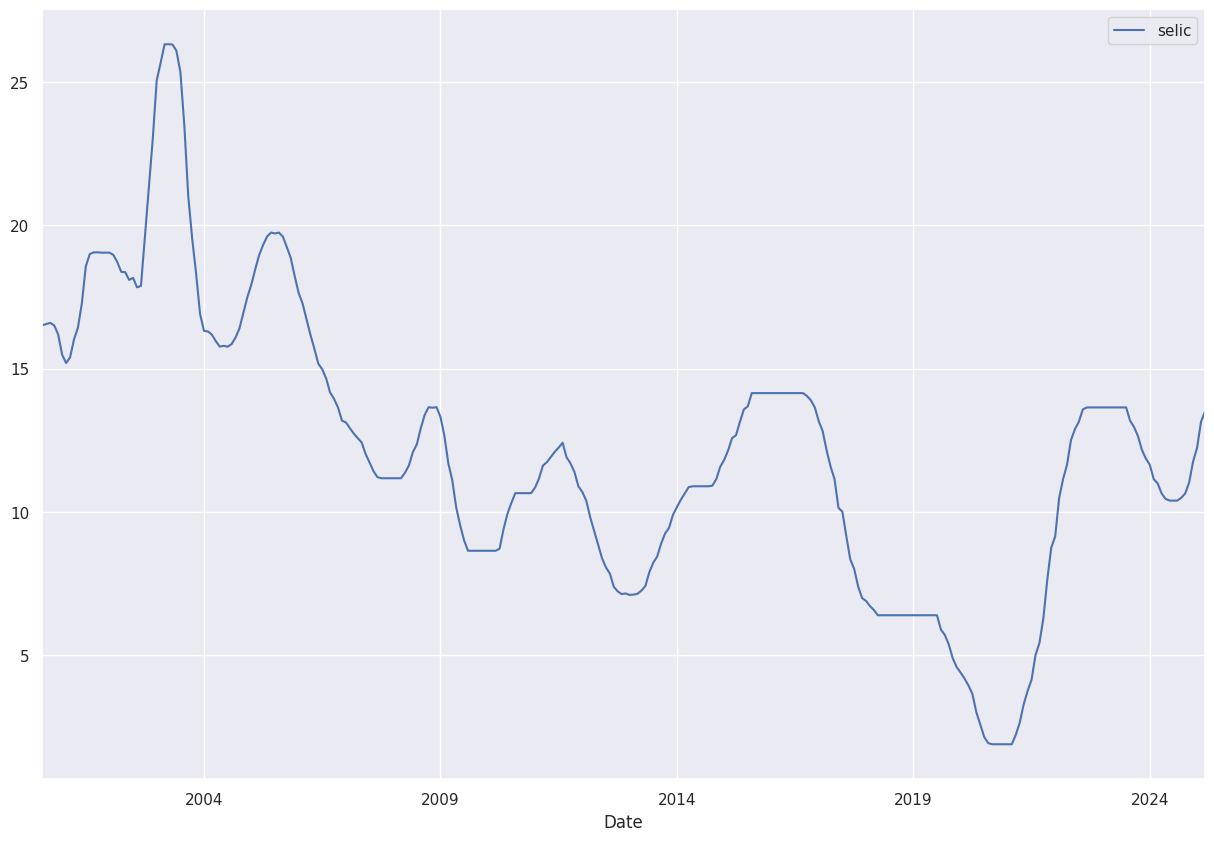

In [16]:
from bcb import sgs

# Busca a série da SELIC no SGS
selic = sgs.get({'selic':4189}, start = '2000-08-07')

# Plota
sns.set_theme()
selic.plot(figsize = (15, 10))

<Axes: xlabel='Date'>

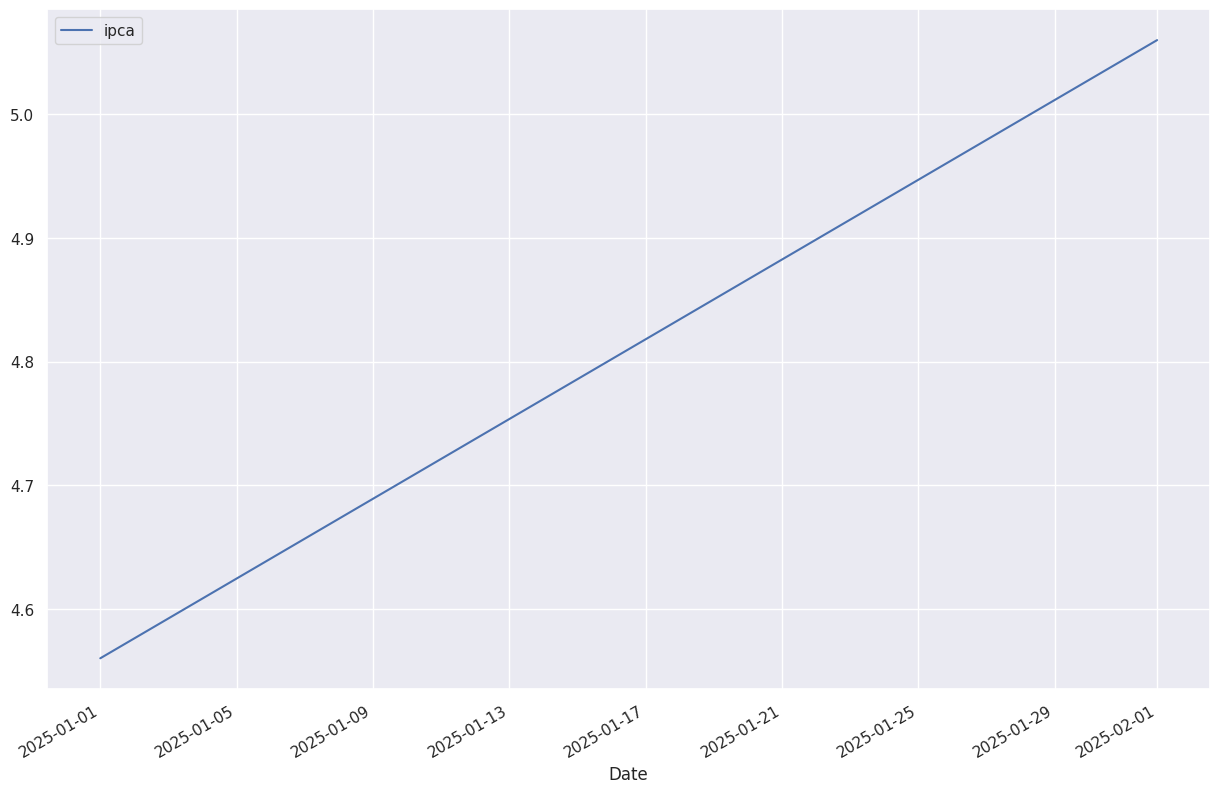

In [100]:
# Busca a série da SELIC no SGS
ipca = sgs.get({'ipca':13522}, start = '2025-01-01')

# Plota
sns.set_theme()
ipca.plot(figsize = (15, 10))

In [101]:
(ipca.dropna()/12).cumsum()

,ipca
Date,
2025-01-01,0.380000
2025-02-01,0.801667


In [105]:
import yfinance as yf
import pandas as pd

def fetch_stock_data(tickers):
    tickers = [i+'.SA' for i in tickers]
    data = yf.download(tickers)['Close'].dropna()
    data.columns = data.columns.str.replace(r'\.SA$', '', regex=True)
    
    return data

data = fetch_stock_data(['WEGE3','EMBR3'])
returns = data.pct_change().dropna()

[*********************100%***********************]  2 of 2 completed


In [107]:
import numpy as np 

def monte_carlo_portfolios(returns, n_simulations=3000):
    results = []
    num_assets = len(returns.columns)

    for _ in range(n_simulations):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        ret = np.sum(returns.mean() * weights) * 252
        vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov()*252, weights)))
        sharpe = ret / vol
        results.append((weights, ret, vol, sharpe))

    results_df = pd.DataFrame(results, columns=['weights', 'return', 'volatility', 'sharpe'])
    return results_df.sort_values(by='sharpe', ascending=False)


In [158]:
from datetime import datetime

period_choice = 'YTD'

today = datetime.today()
if period_choice == 'YTD':
    start_date = datetime(today.year, 1, 1)
elif period_choice == '1 Ano':
    start_date = today - pd.DateOffset(years=1)
elif period_choice == '5 Anos':
    start_date = today - pd.DateOffset(years=5)
else:
    start_date = returns.index[0]


num_simulations = 30000

period_returns = returns[returns.index >= start_date]

valid_period_returns = period_returns.dropna(axis=1, how='any')

In [159]:
monte_carlo_results_period = monte_carlo_portfolios(valid_period_returns, n_simulations=num_simulations)


In [160]:
monte_carlo_results_period['return_pct'] = monte_carlo_results_period['return'] * 100
monte_carlo_results_period['return_pct'] = np.round(monte_carlo_results_period['return_pct'] ,2)
# Slider usa a coluna em percentual
returns_slider = np.round(monte_carlo_results_period['return_pct'].unique(), 2)
returns_slider.sort()
step_slider = max(np.round((returns_slider.max() - returns_slider.min()) / len(returns_slider), 2), 0.01)
optimal_return_period = np.round(monte_carlo_results_period.iloc[0]['return_pct'], 2)

In [161]:
monte_carlo_results_period.head()

,weights,return,volatility,sharpe,return_pct
29048,"[0.9999351604277402, 6.483957225980285e-05]",0.838373,0.544005,1.541111,83.84
14395,"[0.999884056923449, 0.0001159430765510668]",0.838304,0.543980,1.541055,83.83
13295,"[0.9998414428157119, 0.00015855718428814367]",0.838247,0.543960,1.541009,83.82
16097,"[0.9998382773404463, 0.00016172265955375676]",0.838243,0.543958,1.541005,83.82
5588,"[0.9997598481313011, 0.00024015186869883753]",0.838137,0.543920,1.540919,83.81


In [163]:
return_selected_percent = 61.13

monte_carlo_results_period[
        monte_carlo_results_period['return_pct'] == return_selected_percent
    ].iloc[0]

weights       [0.8307078462331198, 0.16929215376688025]
return                                          0.61132
volatility                                     0.465276
sharpe                                         1.313887
return_pct                                        61.13
Name: 10618, dtype: object

In [165]:
closest_idx = (monte_carlo_results_period['return_pct'] - return_selected_percent).abs().idxmin()
monte_carlo_results_period.loc[closest_idx]

weights       [0.8307078462331198, 0.16929215376688025]
return                                          0.61132
volatility                                     0.465276
sharpe                                         1.313887
return_pct                                        61.13
Name: 10618, dtype: object

In [147]:
monte_carlo_results_period['return'].unique()

array([62.05, 62.06, 62.04, ..., 23.86, 23.85, 23.84], shape=(5416,))

In [138]:
returns_slider = np.round(monte_carlo_results_period['return'].unique() / 100, 2)
returns_slider.sort()

In [141]:
returns_slider.min()

np.float64(0.24)

In [128]:
return_selected_percent = 77.59

In [129]:
monte_carlo_results_period[monte_carlo_results_period['return'] == return_selected_percent ]

,weights,return,volatility,sharpe
23815,"[0.9749155609099732, 0.025084439090026753]",77.59,0.430230,1.803468
14458,"[0.9749396806110713, 0.025060319388928737]",77.59,0.430239,1.803462


In [131]:
closest_return_row = monte_carlo_results_period[
    monte_carlo_results_period['return'] == return_selected_percent
].iloc[0]

In [132]:
closest_return_row

weights       [0.9749155609099732, 0.025084439090026753]
return                                             77.59
volatility                                       0.43023
sharpe                                          1.803468
Name: 23815, dtype: object

In [116]:
(monte_carlo_results_period['return'] * 100 - (monte_carlo_results_period['return'].max()*100)).abs().argsort()[0]

np.int64(13774)

In [65]:
best_weights_period = monte_carlo_results_period.iloc[0]['weights']

selected_stocks_saved = ['BBAS3','BBSE3']

final_weights = pd.Series(0.0, index=selected_stocks_saved)

for ticker in valid_period_returns.columns:
    final_weights[ticker] = best_weights_period[valid_period_returns.columns.get_loc(ticker)]

portfolio_cumulative = (valid_period_returns @ best_weights_period + 1).cumprod()

In [71]:
best_weights_period

array([0.24396206, 0.75603794])

In [89]:
portfolio_cumulative = (valid_period_returns @ best_weights_period + 1).cumprod() - 1
portfolio_cumulative

Date
2013-04-30    0.023231
2013-05-02    0.040781
2013-05-03    0.050293
2013-05-06    0.054004
2013-05-07    0.063200
                ...   
2025-03-24    5.344863
2025-03-25    5.332887
2025-03-26    5.382561
2025-03-27    5.406137
2025-03-28    5.403193
Length: 2963, dtype: float64

In [98]:
selic = sgs.get({'selic':4189}, start = '2025-01-01')

In [99]:
(selic.dropna()/12).cumsum()

,selic
Date,
2025-01-01,1.020000
2025-02-01,2.115833
2025-03-01,3.240833


,selic
Date,
2000-08-01,1.376667
2000-09-01,2.756667
2000-10-01,4.140000
2000-11-01,5.515833
2000-12-01,6.865000
...,...
2024-11-01,293.535833
2024-12-01,294.516667
2025-01-01,295.536667


In [1]:
import fundamentus

2025-03-28 21:43:23,635 [logging.log_init] INFO: LOGLEVEL=INFO


In [17]:
df = fundamentus.get_resultado()
df

/home/luisantolin/code/stock_assistant/.stock_assistant/lib/python3.10/site-packages/fundamentus/resultado.py:50: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(content.text, decimal=",", thousands='.')[0]


Multiples,cotacao,pl,pvp,psr,dy,pa,pcg,pebit,pacl,evebit,evebitda,mrgebit,mrgliq,roic,roe,liqc,liq2m,patrliq,divbpatr,c5y
papel,,,,,,,,,,,,,,,,,,,,
AALR3,7.62,-8.99,1.06,0.954,0.0000,0.402,41.42,10.84,-1.10,16.51,8.23,0.0880,-0.0963,0.0397,-0.1179,1.04,3197110.0,1.094790e+09,0.66,0.0595
ABCB3,0.00,0.00,0.00,0.000,0.0000,0.000,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000,0.0000,0.1521,0.00,0.0,6.387350e+09,0.00,0.7429
ABCB4,20.77,5.23,0.80,0.000,0.0792,0.000,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000,0.0000,0.1521,0.00,12445300.0,6.387350e+09,0.00,0.7429
ABEV3,13.43,14.66,2.15,2.366,0.0592,1.302,44.39,10.88,-24.13,9.53,7.07,0.2174,0.1660,0.1790,0.1464,1.10,410849000.0,9.864210e+10,0.04,0.0990
ABYA3,4.91,-214.80,1.76,2.055,0.0000,0.527,1.98,19.96,-2.75,33.67,33.67,0.1029,-0.0096,0.0278,-0.0082,2.09,0.0,2.920600e+08,1.31,0.1641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WLMM4,30.98,8.72,1.46,0.361,0.0448,0.860,2.39,6.25,4.16,7.83,7.58,0.0578,0.0414,0.1511,0.1673,2.40,28104.8,7.732220e+08,0.48,0.2895
WMBY3,25.39,-19.30,2.87,0.836,0.0000,0.182,1.20,8.62,-1.50,25.02,25.02,0.0970,-0.0705,0.0239,-0.1486,1.44,0.0,2.124390e+08,6.51,-0.1448
WSON33,67.00,8.07,0.98,1.067,0.0000,0.400,13.41,2.42,-0.89,5.08,5.08,0.4414,0.1358,0.1836,0.1217,1.26,0.0,2.148530e+09,1.21,0.0523


In [45]:
df.columns

Index(['cotacao', 'pl', 'pvp', 'psr', 'dy', 'pa', 'pcg', 'pebit', 'pacl',
       'evebit', 'evebitda', 'mrgebit', 'mrgliq', 'roic', 'roe', 'liqc',
       'liq2m', 'patrliq', 'divbpatr', 'c5y'],
      dtype='object', name='Multiples')

In [19]:
df_p = fundamentus.get_papel('BBAS3')

2025-03-28 21:48:37,651 [detalhes.get_papel] INFO: detalhes: call: get..._papel()
/home/luisantolin/code/stock_assistant/.stock_assistant/lib/python3.10/site-packages/fundamentus/detalhes.py:232: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables_html = pd.read_html(content.text, decimal=",", thousands='.')


In [21]:
df_p.columns

Index(['Papel', 'Tipo', 'Empresa', 'Setor', 'Subsetor', 'Cotacao',
       'Data_ult_cot', 'Min_52_sem', 'Max_52_sem', 'Vol_med_2m',
       'Valor_de_mercado', 'Valor_da_firma', 'Ult_balanco_processado',
       'Nro_Acoes', 'PL', 'PVP', 'PEBIT', 'PSR', 'PAtivos', 'PCap_Giro',
       'PAtiv_Circ_Liq', 'Div_Yield', 'EV_EBITDA', 'EV_EBIT', 'Cres_Rec_5a',
       'LPA', 'VPA', 'Marg_Bruta', 'Marg_EBIT', 'Marg_Liquida', 'EBIT_Ativo',
       'ROIC', 'ROE', 'Liquidez_Corr', 'Div_Br_Patrim', 'Giro_Ativos', 'Ativo',
       'Cart_de_Credito', 'Depositos', 'Patrim_Liq', 'Result_Int_Financ_12m',
       'Rec_Servicos_12m', 'Lucro_Liquido_12m', 'Result_Int_Financ_3m',
       'Rec_Servicos_3m', 'Lucro_Liquido_3m'],
      dtype='object')

In [25]:
df_p['Ult_balanco_processado']

BBAS3    2024-12-31
Name: Ult_balanco_processado, dtype: object

In [25]:
import pandas as pd
import fundamentus

stocks = ['WEGE3','EMBR3','PETR4','BBAS3','BBSE3']

df_p = pd.DataFrame();
for s in stocks:
    df_p = pd.concat([df_p,fundamentus.get_papel(s)])

2025-03-30 19:31:56,290 [detalhes.get_papel] INFO: detalhes: call: get..._papel()
/home/luisantolin/code/stock_assistant/.stock_assistant/lib/python3.10/site-packages/fundamentus/detalhes.py:232: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables_html = pd.read_html(content.text, decimal=",", thousands='.')
2025-03-30 19:31:56,333 [detalhes.get_papel] INFO: detalhes: call: get..._papel()
/home/luisantolin/code/stock_assistant/.stock_assistant/lib/python3.10/site-packages/fundamentus/detalhes.py:232: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables_html = pd.read_html(content.text, decimal=",", thousands='.')
2025-03-30 19:31:56,370 [detalhes.get_papel] INFO: detalhes: call: get..._papel()
/home/luisantolin/code/stock_assistant/.stock_

In [5]:
df_p.columns

Index(['Papel', 'Tipo', 'Empresa', 'Setor', 'Subsetor', 'Cotacao',
       'Data_ult_cot', 'Min_52_sem', 'Max_52_sem', 'Vol_med_2m',
       'Valor_de_mercado', 'Valor_da_firma', 'Ult_balanco_processado',
       'Nro_Acoes', 'PL', 'PVP', 'PEBIT', 'PSR', 'PAtivos', 'PCap_Giro',
       'PAtiv_Circ_Liq', 'Div_Yield', 'EV_EBITDA', 'EV_EBIT', 'Cres_Rec_5a',
       'LPA', 'VPA', 'Marg_Bruta', 'Marg_EBIT', 'Marg_Liquida', 'EBIT_Ativo',
       'ROIC', 'ROE', 'Liquidez_Corr', 'Div_Br_Patrim', 'Giro_Ativos', 'Ativo',
       'Disponibilidades', 'Ativo_Circulante', 'Div_Bruta', 'Div_Liquida',
       'Patrim_Liq', 'Receita_Liquida_12m', 'EBIT_12m', 'Lucro_Liquido_12m',
       'Receita_Liquida_3m', 'EBIT_3m', 'Lucro_Liquido_3m', 'Cart_de_Credito',
       'Depositos', 'Result_Int_Financ_12m', 'Rec_Servicos_12m',
       'Result_Int_Financ_3m', 'Rec_Servicos_3m'],
      dtype='object')

In [26]:
df_p[['Cotacao','Empresa','Setor','Div_Yield','PL','PVP','Div_Br_Patrim','ROIC']]

,Cotacao,Empresa,Setor,Div_Yield,PL,PVP,Div_Br_Patrim,ROIC
WEGE3,45.85,WEG SA ON N1,Máquinas e Equipamentos,1.7%,3185,867,016,28.7%
EMBR3,66.36,EMBRAER ON,Material de Transporte,0.0%,2561,258,081,6.8%
PETR4,37.43,PETROBRAS PN,"Petróleo, Gás e Biocombustíveis",21.3%,1318,132,102,20.2%
BBAS3,28.64,BANCO DO BRASIL S.A. ON,Intermediários Financeiros,9.1%,465,091,-,-
BBSE3,40.26,BBSEGURIDADE ON NM,Previdência e Seguros,9.2%,925,830,-,-


In [27]:
df.columns

Index(['cotacao', 'pl', 'pvp', 'psr', 'dy', 'pa', 'pcg', 'pebit', 'pacl',
       'evebit', 'evebitda', 'mrgebit', 'mrgliq', 'roic', 'roe', 'liqc',
       'liq2m', 'patrliq', 'divbpatr', 'c5y'],
      dtype='object', name='Multiples')

In [28]:
df_p = pd.concat([df_p[['Empresa','Setor','Div_Br_Patrim']],df[['dy','pl','pvp','roic']]],axis = 1).dropna()

In [29]:
df_p['Div_Br_Patrim'] = df_p.Div_Br_Patrim.replace('-',None).astype(float) / 100


In [30]:
df_p['dy'] = df_p.dy*100
df_p

,Empresa,Setor,Div_Br_Patrim,dy,pl,pvp,roic
WEGE3,WEG SA ON N1,Máquinas e Equipamentos,0.16,1.71,31.85,8.67,0.2870
EMBR3,EMBRAER ON,Material de Transporte,0.81,0.00,25.61,2.58,0.0682
PETR4,PETROBRAS PN,"Petróleo, Gás e Biocombustíveis",1.02,21.29,13.18,1.32,0.2022
BBAS3,BANCO DO BRASIL S.A. ON,Intermediários Financeiros,NaN,9.13,4.65,0.91,0.0000
BBSE3,BBSEGURIDADE ON NM,Previdência e Seguros,NaN,9.20,9.25,8.30,0.0000


In [50]:
fundamentus.get_papel()

TypeError: get_papel() missing 1 required positional argument: 'param'

In [51]:
sectors = pd.read_csv('sectors.csv')

In [57]:
df_p = pd.DataFrame();
for s in sectors.tick:
    df_p = pd.concat([df_p,fundamentus.get_papel(s)])

2025-03-28 22:23:04,707 [detalhes.get_papel] INFO: detalhes: call: get..._papel()
/home/luisantolin/code/stock_assistant/.stock_assistant/lib/python3.10/site-packages/fundamentus/detalhes.py:232: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables_html = pd.read_html(content.text, decimal=",", thousands='.')
2025-03-28 22:23:05,422 [detalhes.get_papel] INFO: detalhes: call: get..._papel()
/home/luisantolin/code/stock_assistant/.stock_assistant/lib/python3.10/site-packages/fundamentus/detalhes.py:232: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables_html = pd.read_html(content.text, decimal=",", thousands='.')
2025-03-28 22:23:06,136 [detalhes.get_papel] INFO: detalhes: call: get..._papel()
/home/luisantolin/code/stock_assistant/.stock_

In [63]:
sectors.head()

,sector,tick,stock_name,class_type,volume,share_prc,acumm_share_prc,sector_id
0,Máqs e Equips,ARML3,ARMAC,ON NM,171598756,0.035,3.103,20
1,Máqs e Equips,KEPL3,KEPLER WEBER,ON NM,174021783,0.058,3.103,20
2,Máqs e Equips,MILS3,MILLS,ON NM,170940549,0.070,3.103,20
3,Máqs e Equips,TASA4,TAURUS ARMAS,PN N2,67442691,0.024,3.103,20
4,Máqs e Equips,WEGE3,WEG,ON EJ NM,1482105837,2.916,3.103,20


In [59]:
df_p.head()

,Papel,Tipo,Empresa,Setor,Subsetor,Cotacao,Data_ult_cot,Min_52_sem,Max_52_sem,Vol_med_2m,...,Lucro_Liquido_12m,Receita_Liquida_3m,EBIT_3m,Lucro_Liquido_3m,Cart_de_Credito,Depositos,Result_Int_Financ_12m,Rec_Servicos_12m,Result_Int_Financ_3m,Rec_Servicos_3m
ARML3,ARML3,ON NM,ARMAC ON NM,Diversos,Aluguel de carros,4.05,2025-03-28,4.05,12.13,5750000,...,170197000,473494000,98388000,9752990,NaN,NaN,NaN,NaN,NaN,NaN
KEPL3,KEPL3,ON,KEPLER WEBER SA ON,Máquinas e Equipamentos,Máq. e Equip. Industriais,7.80,2025-03-28,7.33,11.39,13471800,...,199183000,460100000,75060000,50382000,NaN,NaN,NaN,NaN,NaN,NaN
MILS3,MILS3,ON NM,MILLS ON NM,Diversos,Aluguel de carros,9.59,2025-03-28,8.17,13.26,7400280,...,284890000,432568000,157138000,75591000,NaN,NaN,NaN,NaN,NaN,NaN
TASA4,TASA4,PN,TAURUS ARMAS PN,Máquinas e Equipamentos,Armas e Munições,8.26,2025-03-28,7.95,12.89,1696210,...,76592000,455244000,46808000,40501000,NaN,NaN,NaN,NaN,NaN,NaN
WEGE3,WEGE3,ON N1,WEG SA ON N1,Máquinas e Equipamentos,"Motores, Compressores e Outros",45.85,2025-03-28,36.78,58.03,369965000,...,6042590000,10822300000,2358950000,1694300000,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
sector = []; company = []
for s in sectors.tick:
    sector.append(df_p[df_p['Papel']==s].reset_index(drop=True).Setor[0])
    company.append(df_p[df_p['Papel']==s].reset_index(drop=True).Empresa[0])


In [75]:
sectors['sector'] = sector
sectors['stock_name'] = company

In [77]:
sectors.to_csv('/home/luisantolin/code/stock_assistant/sectors.csv',index=False)

In [42]:
import numpy as np

np.sum(np.array([0.59729048, 0.00240757 ,0.40030195]) * np.array([0. ,  0.  , 0.43]))/3

np.float64(0.05737661283333333)

In [48]:
sum([ 9.13*0.23141696,7.48*0.07815716,21.29*0.35630397,4.5*0.04878774,3.67*0.00879047,1.71*0.27654371])/6

1.8346432536500004

In [32]:
0.3*9.13+0*0.45+3.67+0.0002+1.71*0.238

6.816180000000001